![](./figures/Logo.PNG)

Please click the <span>&#x23E9;</span> button to run all cells before you start working on the notebook ...

## In this part of the tutorial, you will
* analyse dynamic model outputs visually
* analyse the model residuals (the difference between observed and simulated)

- - -

# 2a - Visual Model Output Inspection

- - -

## 1. Model Outputs

To understand the quality of our model, we mainly focus on the results that the model produces for different parameter sets and reference observations.

1. A key initial step in model output analysis is **visual inspection** of the simulated time series using various plots. Where observations are available, these can be compared with the simulation results. You will do this in the first task. 

2. When data does not follow a normal distribution, we can ues the [**Box-Cox Transformation**](https://doi.org/10.1111/j.2517-6161.1964.tb00553.x) to transform the data before we look at it. The resulting graph highlights different aspects of the time series, some of which may have not been visible beforehand . You will do this in the second task.

4. Using **scatterplots** of observed values against simulated results we can check for sections in which the model over- or underpredicts the observations. You will do this in the third task.

5. Importantly, we can study the [**residuals**](https://en.wikipedia.org/wiki/Errors_and_residuals) of a model, e.g. the difference between observed and simulated values. They are helpful to quantify the differences that you may observe in the above mentioned scatterplots. You will do this in the last task.

---

## 2. Visual Inspection of Model Output

**Import packages**

In [1]:
import sys
sys.path.append('src/')
import scipy
import random
import HBV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipywidgets import interact, Dropdown

In [2]:
def hbv(param, precip, temp, pet):
    # Run HBV snow routine
    p_s, _, _ = HBV.snow_routine(param[:4], temp, precip)
    # Run HBV runoff simulation
    Case = 1 # for now we assume that the preferred path in the upper zone is runoff (Case = 1), it can be set to percolation (Case = 2)
    ini = np.array([0,0,0]) # initial state
    runoff_sim, _, _ = HBV.hbv_sim(param[4:], p_s, pet, 1, ini)
    return runoff_sim

### 2.1. Read Catchment Data, Prepare Model Input

In [3]:
# DO NOT ALTER! code to select the catchment

catchment_names = ["Medina River, TX, USA", "Siletz River, OR, USA", "Trout River, BC, Canada"]
catchment_dropdown = Dropdown(options=catchment_names,
                              description="Catchment:",
                              disabled=False)
display(catchment_dropdown)

Dropdown(description='Catchment:', options=('Medina River, TX, USA', 'Siletz River, OR, USA', 'Trout River, BC…

In [4]:
def load_catchment_data(catchment_name):
    file_dic = {"Siletz River, OR, USA": "camels_14305500", "Medina River, TX, USA": "camels_08178880", "Trout River, BC, Canada": "hysets_10BE007"}
    
    start_date = '2002-10-01'
    end_date   = '2004-09-30'
    
    df_obs         = pd.read_csv(f"./data/{file_dic[catchment_name]}.csv")       
    df_obs.date    = pd.to_datetime(df_obs['date'], format='%Y-%m-%d')  # convert date string to datetime 
    df_obs         = df_obs.set_index('date')                           # use date as index
    df_obs         = df_obs[start_date:end_date]                        # select between start date and end dat
    df_obs["date"] = df_obs.index.map(lambda s: s.strftime('%b-%d-%y')) # again, add a date column for plotting 
    df_obs         = df_obs.reset_index(drop=True)         
    df_obs         = df_obs[["snow_depth_water_equivalent_mean", "total_precipitation_sum","potential_evaporation_sum", "streamflow", "temperature_2m_mean", "date"]]
    df_obs.columns = ["Snow [mm/day]", "P [mm/day]", "PET [mm/day]", "Q [mm/day]", "T [C]", "Date"]

    return df_obs

# load the selected catchment
df_obs = load_catchment_data(catchment_dropdown.value)

# read calibrated parameters
df_par   = pd.read_csv("data/calibrated_parameters - HBV.csv")
df_par   = df_par[df_par["catchment_name"] == catchment_dropdown.value]       # only select the parameters for this catchment
obj_funs = df_par["objective_function"]                             # extract obj_funs for which there are parameters

### 2.2. Comparing Simulated and Observed Hydrographs

In [5]:
@interact(obj_fun=Dropdown(options=zip([f"Run #{i + 1}" for i in range(len(obj_funs))], obj_funs), description="Which:"))
def plot_hydrographs(obj_fun):

    i = list(obj_funs).index(obj_fun)
    
    fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    
    # plot the observed data
    axs[0].plot(df_obs["Date"], df_obs["Q [mm/day]"], color="black", label="Observed")
    axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
    # plot precipitation on inverted axis
    axi = axs[0].twinx()
    axi.invert_yaxis()
    axi.bar(df_obs["Date"], df_obs["P [mm/day]"], alpha=0.5)
    axi.set_ylabel("Precipitation [mm]")
    axi.set_ylim(axi.get_ylim()[0]*1.5, 0)
    
    # extract parameters and run HBV
    P, temp, evap = df_obs[["P [mm/day]", "T [C]", "PET [mm/day]"]].to_numpy().T
    params = df_par[df_par.objective_function == obj_fun].iloc[0,3:].to_numpy()
    Q_sim  = hbv(params, P, temp, evap)
    
    # plot the simulated hydrograph and model residuals
    axs[0].plot(df_obs["Date"], Q_sim, color=f"C{i + 1}", label=f"Simulated\n(using {obj_fun})")
    axs[1].plot(df_obs["Date"], Q_sim - df_obs["Q [mm/day]"], color=f"C{i + 1}", ls="--", label=f"Simulated\n(using {obj_fun})")
    
    fig.suptitle(catchment_dropdown.value)
    axs[0].set_title(f"Hydrographs")
    axs[1].set_title(f"Model Residuals")
    axs[0].legend()
    axs[1].legend()
    axs[0].set_ylabel("Runoff [mm/day]")
    axs[1].set_ylabel("Residual [mm/day]")
    
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Which:', options=(('Run #1', 'bias'), ('Run #2', 'rmse'), ('Run #3…

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task I: Compare Observed and Simulated Hydrographs</h4>
    <p>For each of the three catchments, we have prepared HBV runs for which the model parameters have been optimized using different loss functions, e.g. ways to compute the goodness of fit for the model. While we discuss the details of how these loss functions work in the next tutorial, we can already discuss the differences between their corresponding hydrographs.</p>
    <p>You can change which model run to look at in the dropdown above the plot. Remember that there are three catchments you can look at!</p>
    <ol>
        <li>What parts of the hydrographs do the different model runs reproduce well or poorly? Think about timing, scales, ...</li>
        <li>What other aspects of model performance might be interesting but not captured in these plots?</li>
    </ol>
</div>

_PUT YOUR ANSWERS HERE_

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue;">
</div>

### 2.3. Using the Box-Cox Transformation

The [Box-Cox transformation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) is a family of power transformations used to stabilize variance and make data more normally distributed. It is particularly useful when dealing with data that shows heteroscedasticity or non-normality. The Box-Cox transformation is used to stabilize variance and improve the normality of data, which can enhance the performance of statistical methods that assume normally distributed errors.

The transformation is defined as:

$$
y(\lambda) = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\
\log(y) & \text{if } \lambda = 0
\end{cases}
$$

where:
- $y$ is the original data value,
- $\lambda$ (lambda) is the transformation parameter,
- $y(\lambda)$ is the transformed data value.

The parameter $\lambda$ is typically chosen to maximize the log-likelihood function of the transformed data under the assumption of normality. Common values include $\lambda = 1$ (no transformation), $\lambda = 0.5$ (square root transformation), and $\lambda = -1$ (reciprocal transformation).

In [6]:
@interact(obj_fun=Dropdown(options=zip([f"Run #{i + 1}" for i in range(len(obj_funs))], obj_funs), description="Which:"), lmbda = (0.0, 5.0, 0.01))
def plot_hydrographs(obj_fun, lmbda = 0.15):

    i = list(obj_funs).index(obj_fun)
    
    fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)

    # plot the observed data using Box-Cox transformation
    axs[0].plot(df_obs["Date"], scipy.special.boxcox1p(df_obs["Q [mm/day]"], lmbda), color="black", label="Observed")
    axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
    # plot precipitation on inverted axis
    axi = axs[0].twinx()
    axi.invert_yaxis()
    axi.bar(df_obs["Date"], df_obs["P [mm/day]"], alpha=0.5)
    axi.set_ylabel("Precipitation [mm]")
    axi.set_ylim(axi.get_ylim()[0]*1.5, 0)
    
    # extract parameters and run HBV
    P, temp, evap = df_obs[["P [mm/day]", "T [C]", "PET [mm/day]"]].to_numpy().T
    params = df_par[df_par.objective_function == obj_fun].iloc[0,3:].to_numpy()
    Q_sim  = hbv(params, P, temp, evap)

    # Box-Cox Transformation
    Q_sim  = scipy.special.boxcox1p(Q_sim, lmbda)

    # plot the simulated hydrograph and model residuals
    axs[0].plot(df_obs["Date"], Q_sim, color=f"C{i + 1}", label=f"Simulated\n(using {obj_fun})")
    axs[1].plot(df_obs["Date"], Q_sim - df_obs["Q [mm/day]"], color=f"C{i + 1}", ls="--", label=f"Simulated\n(using {obj_fun})")
    
    fig.suptitle(catchment_dropdown.value)
    axs[0].set_title(f"Hydrographs (Box-Cox transformed)")
    axs[1].set_title(f"Model Residuals (Box-Cox transformed)")
    axs[0].legend()
    axs[1].legend()
    axs[0].set_ylabel("Runoff [mm/day]")
    axs[1].set_ylabel("Residual [mm/day]")
    
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Which:', options=(('Run #1', 'bias'), ('Run #2', 'rmse'), ('Run #3…

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task II: Box-Cox Transformation</h4>
    <p>Above, you find the same hydrographs and residuals as before. They are however previously transformed using the Box-Cox transformation.</p>
    <p>You can change which model run to look at in the dropdown above the plot and the transformation parameter with the slider. Remember that there are three catchments you can look at!</p>
    <ol>
        <li>How does the transformation parameter (lambda) affect the hydrographs?</li>
        <li>Compared to your previous results, what benefits does the Box-Cox transformation offer in comparing the hydrographs?</li>
        <li>How would you define an optimal lambda parameter? What characterstics are then seen in the hydrograph?</li>
    </ol>
</div>

_PUT YOUR ANSWERS HERE_

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue;">
</div>

### 2.4. Using scatter plots of observed values against simulated values to determine over- and underprediction

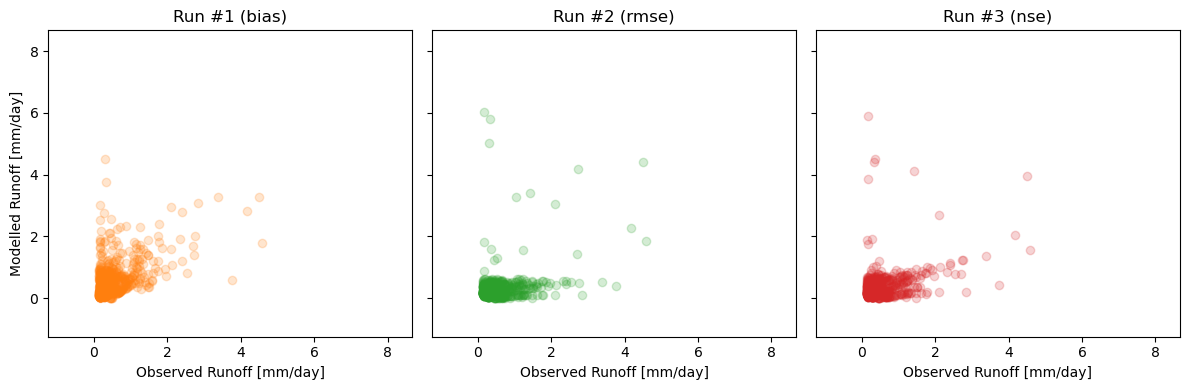

In [7]:
fig, axs = plt.subplots(1, len(obj_funs), figsize=(4*len(obj_funs), 4), squeeze=False, sharey=True, sharex=True)

for i, (obj_fun, ax) in enumerate(zip(obj_funs, axs[0])):

    # extract parameters and run HBV
    P, temp, evap = df_obs[["P [mm/day]", "T [C]", "PET [mm/day]"]].to_numpy().T
    params = df_par[df_par.of == obj_fun].iloc[0, 3:].to_numpy()
    Q_sim  = hbv(params, P, temp, evap)
    
    # scatter plot simulated vs. observed hydrographs
    ax.scatter(df_obs["Q [mm/day]"], Q_sim, alpha=0.2, color=f"C{i + 1}")
    lims = np.array([ax.get_xlim(), ax.get_ylim()]).max(axis=0)*0.75 + np.array([-0.5, 0.5]) # perfect fit would have 45° angle
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    ax.set_title(f"Run #{i + 1} ({obj_fun})")
    ax.set_xlabel("Observed Runoff [mm/day]")

axs[0, 0].set_ylabel("Modelled Runoff [mm/day]")

plt.tight_layout()
plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task III: Over- and Underprediction</h4>
    These scatterplots show the simulated (modelled) runoff over the observed runoff. Each plot corresponds to one of the above-mentioned loss functions.
    <ol>
        <li>When you only look at the scatterplots: what does the model capture well and were does it behave poorly.</li>
        <li>How does this compare to your results from Task 1?</li>
        <li>How would such a scatterplot look for a model that perfectly captures reality?</li>
        <li>Can you think of ways to adjust the scatterplot so that they could be even more informative? Feel free and try to implement your idea in the code!</li>
    </ol>
</div>

_PUT YOUR ANSWERS HERE_

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue;">
</div>

### 2.5. Analysing Residuals

In the context of the HyMOD hydrological model, model residuals represent the differences between observed streamflow values and those predicted by the model. They are a measure of the model's performance in capturing the actual hydrological behavior.

For a given time step, the residual is calculated as:

$$
\text{Residual} = \text{Observed Streamflow} - \text{Predicted Streamflow}
$$

Analyzing residuals helps assess the accuracy of the HyMOD model. Ideally, residuals should be randomly distributed with no discernible pattern, indicating that the model effectively represents the underlying hydrological processes. Patterns or systematic deviations in residuals may suggest areas where the model could be improved, such as adjustments to parameters or incorporation of additional factors.

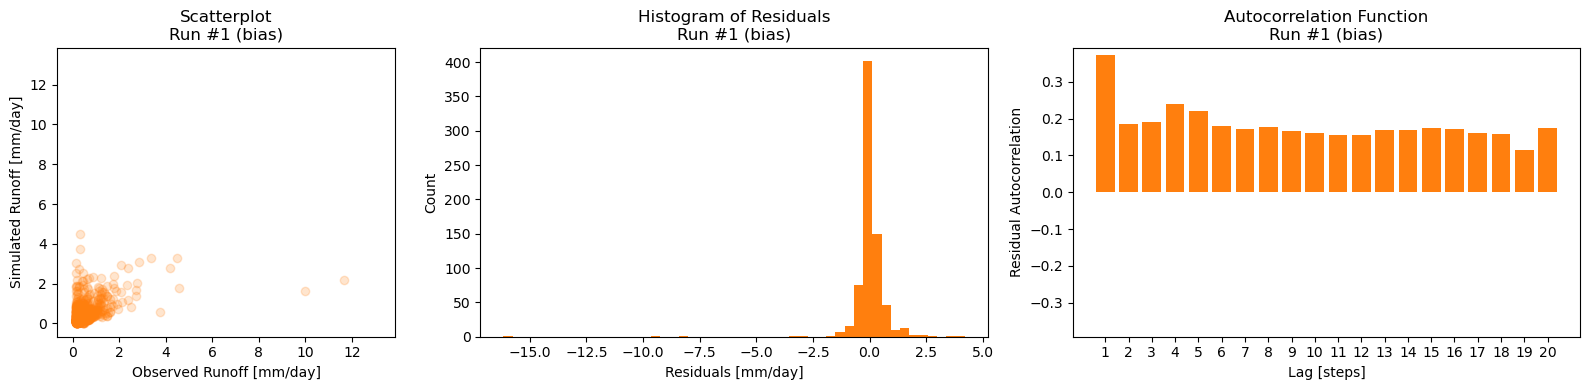

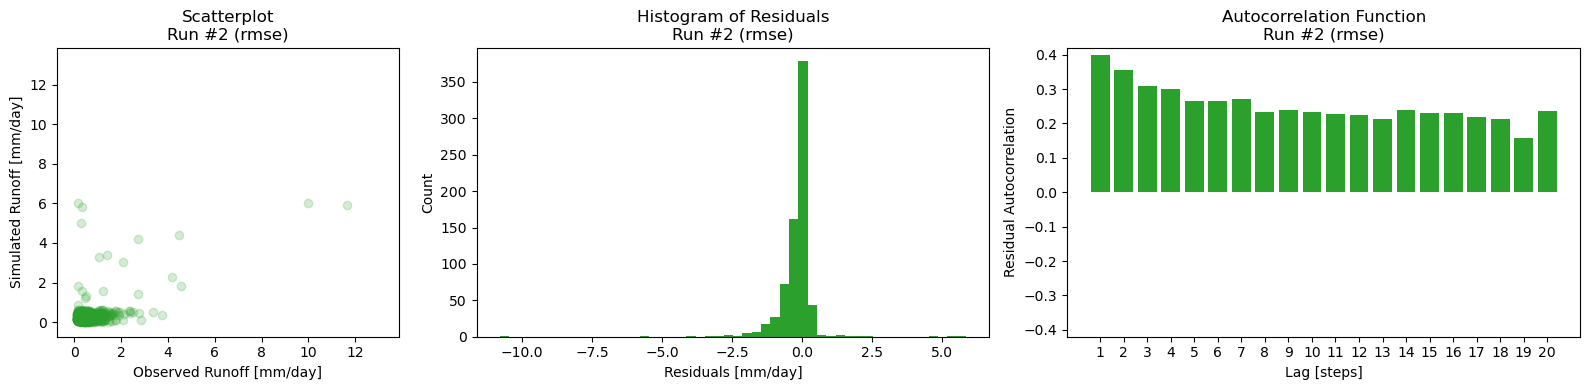

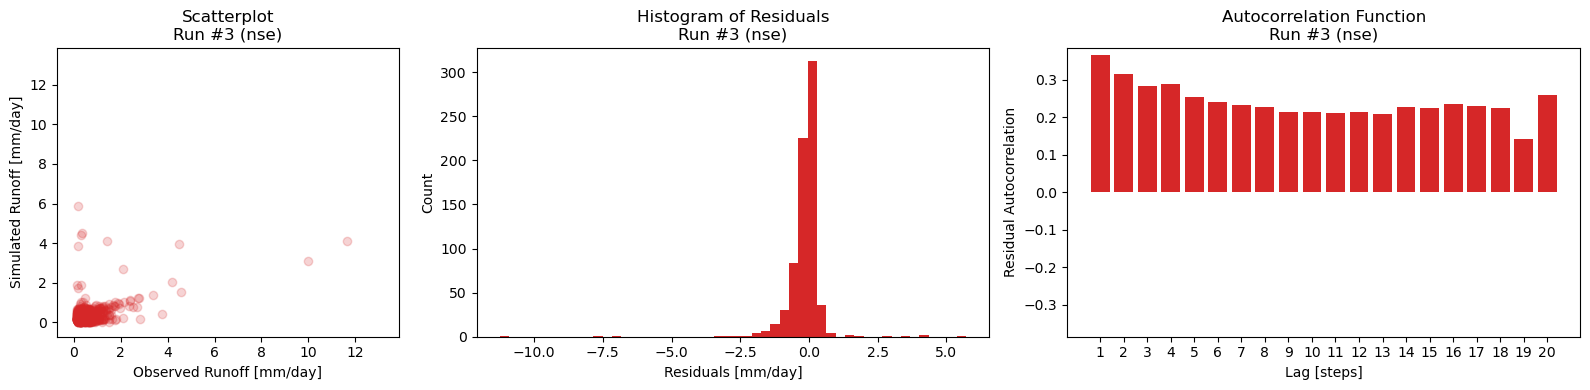

In [8]:
for i, obj_fun in enumerate(obj_funs):

    fig, axs = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw={"width_ratios": [1, 1.5, 1.5]})
    
    # extract parameters and run HBV
    P, temp, evap = df_obs[["P [mm/day]", "T [C]", "PET [mm/day]"]].to_numpy().T
    params = df_par[df_par.of == obj_fun].iloc[0, 3:].to_numpy()
    Q_sim  = hbv(params, P, temp, evap)

    # calculate autorcorrelation of residuals (pearson correlation with shifted self)
    lags      = range(1, 21)
    residuals = pd.Series(Q_sim - df_obs["Q [mm/day]"])
    autocorr  = [residuals.autocorr(lag) for lag in lags]
    
    # PLOT 1: scatter plot simulated vs. observed hydrographs
    axs[0].scatter(df_obs["Q [mm/day]"], Q_sim, alpha=0.2, color=f"C{i + 1}")
    lims = np.array([axs[0].get_xlim(), axs[0].get_ylim()]).max(axis=0)*0.75 + np.array([-0.5, 0.5]) # perfect fit would have 45° angle
    axs[0].set_title(f"Scatterplot\nRun #{i + 1} ({obj_fun})")
    axs[0].set_xlim(lims)
    axs[0].set_ylim(lims)
    axs[0].set_xlabel("Observed Runoff [mm/day]")
    axs[0].set_ylabel("Simulated Runoff [mm/day]")
    
    # PLOT 2: histogram of residuals
    axs[1].hist(Q_sim - df_obs["Q [mm/day]"], color=f"C{i + 1}", bins=50)
    axs[1].set_title(f"Histogram of Residuals\nRun #{i + 1} ({obj_fun})")
    axs[1].set_xlabel("Residuals [mm/day]")
    axs[1].set_ylabel("Count")
    
    # PLOT 3: autocorrelation
    axs[2].bar(lags, autocorr, color=f"C{i + 1}")
    lim = np.abs(np.array(axs[2].get_ylim())).max()
    axs[2].set_title(f"Autocorrelation Function\nRun #{i + 1} ({obj_fun})")
    axs[2].set_ylim(-lim, lim)
    axs[2].set_xticks(lags, lags)
    axs[2].set_xlabel("Lag [steps]")
    axs[2].set_ylabel("Residual Autocorrelation")
    
    plt.tight_layout()
    plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Your Turn IV: Analysing Residuals</h4>
    We now look at models residuals, e.g. the difference between simulated and observed values. The left column again shows the scatterplots of simulated and observed runoff. The middle column shows a histogram of the residuals and the right column the <a href="https://en.wikipedia.org/wiki/Autocorrelation">autocorrelation</a> of these residuals.
    <ol>
        <li>Can you read the residuals directly from the scatterplot? Can you find areas in which the model over- or underpredicts the observed runoff?</li>
        <li>What insights can you gain from the residual distribution?</li>
        <li>What insights can you gain from the autocorrelation of the residuals?</li>
    </ol>
</div>

_PUT YOUR ANSWERS HERE_

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue;">
</div>